In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
from sklearn.cluster import DBSCAN
import time
from sklearn.metrics import silhouette_score

# Titanic dataset

Data source: https://www.kaggle.com/c/titanic

#### Data Dictionary

|Variable|Definition|Key|
|:-------|:-------|:--------|
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancĂ©s were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

# Titanic data preprocessing

In [183]:
df = pd.read_csv('titanic.csv', index_col=0)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


## How many passangers survived?

In [184]:
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

## We need to pre-process the data first
- We want to use only numerical attributes as a model features
- Certain attributes need to be dropped and some of them can be encoded

### Which features would you drop and why?
### Which features could be encoded and which methods would you use?

In [185]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [186]:
df.describe(exclude=np.number)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644


In [187]:
df.describe(include=np.number)

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## How many values are missing in the individual attributes?

In [188]:
df.isna().sum().sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
Name          0
Pclass        0
Survived      0
Sex           0
Parch         0
SibSp         0
Fare          0
Ticket        0
dtype: int64

## Let's drop Name and Ticket features - these have no use for us now

In [189]:
df = df.drop(['Name', 'Ticket'], axis=1)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NaN,S
2,1,1,female,38.0,1,0,71.2833,C85,C
3,1,3,female,26.0,0,0,7.9250,NaN,S
4,1,1,female,35.0,1,0,53.1000,C123,S
5,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,NaN,S
888,1,1,female,19.0,0,0,30.0000,B42,S
889,0,3,female,NaN,1,2,23.4500,NaN,S


## Extract the deck identifier from the Cabin feature
- Note: A = top deck, G = lowest deck
- Change type to string
- Filter the first letter using *apply* function
- If the value is *nan* use *U* value as an replacement - this will mark the passangers with missing Cabin value
- Replace the T value with A

In [190]:
df.Cabin = df.Cabin.astype(str).apply(lambda x: x[0] if x != 'nan' else 'U').replace({'T': 'A'})

In [191]:
df.Cabin.value_counts()

Cabin
U    687
C     59
B     47
D     33
E     32
A     16
F     13
G      4
Name: count, dtype: int64

## The Age feature is tricky, we have multiple solutions for this, e.g.:
- Drop the feature
- Take the mean/median value to replace the missing value
- Take a random list of ages that maintains the original statistical summary values.
- Use a model to predict values based on the existing values.

### We will use the second option

<Axes: ylabel='Age'>

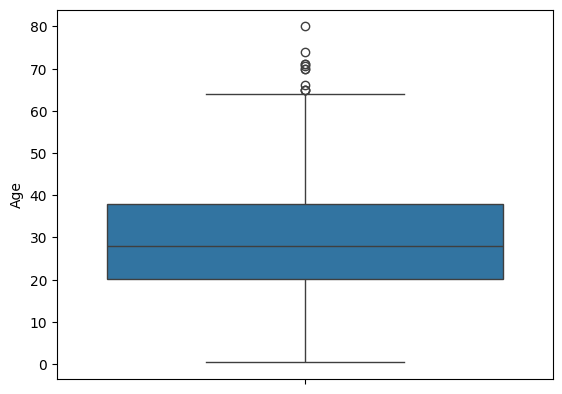

In [192]:
sns.boxplot(y=df.Age)

In [193]:
df.Age = df.Age.fillna(df.Age.mean())

<Axes: ylabel='Age'>

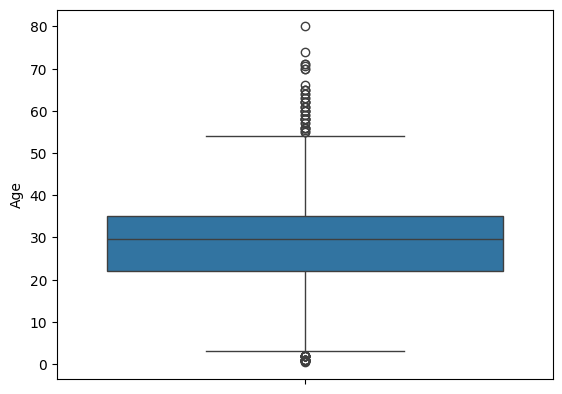

In [194]:
sns.boxplot(y=df.Age)

## Two passangers don't have the Embarked filled - we can drop these two rows

In [195]:
df = df.dropna().copy()

In [196]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.000000,1,0,7.2500,U,S
2,1,1,female,38.000000,1,0,71.2833,C,C
3,1,3,female,26.000000,0,0,7.9250,U,S
4,1,1,female,35.000000,1,0,53.1000,C,S
5,0,3,male,35.000000,0,0,8.0500,U,S
...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.000000,0,0,13.0000,U,S
888,1,1,female,19.000000,0,0,30.0000,B,S
889,0,3,female,29.699118,1,2,23.4500,U,S


## The last step of the pre-processing pipeline is to encode Sex, Cabin and Embarked features
- We will use one-hot encoding for Sex and Embarked and Ordinal encoding for Cabin
- Specify the encoding scheme for the ordinal encoding using an array in a form ['first', 'second', 'third', ...]

In [197]:
cabin_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'U']
enc_cabin = sklearn.preprocessing.OrdinalEncoder(categories=[cabin_categories])
enc_cabin.fit_transform(df[['Cabin']])[:, 0]

array([7., 2., 7., 2., 7., 7., 4., 7., 7., 7., 6., 2., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 3., 7., 0., 7., 7., 7., 2., 7., 7., 7., 1., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 3., 7., 1., 2., 7., 7., 7., 7., 7., 2., 7., 7., 7., 5., 7., 7.,
       7., 7., 7., 7., 7., 7., 5., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 2., 7., 7., 7., 4., 7., 7., 7., 0., 3., 7., 7., 7., 7., 3.,
       7., 7., 7., 7., 7., 7., 7., 2., 7., 7., 7., 7., 7., 7., 7., 1., 7.,
       7., 7., 7., 4., 3., 7., 7., 7., 5., 7., 7., 7., 7., 7., 7., 7., 3.,
       2., 7., 1., 7., 7., 7., 7., 7., 7., 7., 7., 5., 7., 7., 2., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 4., 7., 7., 7., 1.,
       7., 7., 7., 0., 7., 7., 2., 7., 7., 7., 7., 7., 5., 7., 0., 7., 7.,
       7., 7., 7., 7., 7., 5., 1., 1., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       6., 7., 7., 7., 0., 7., 7., 7., 7., 7., 3., 7., 7., 3., 7., 7., 7.,
       7., 7., 2., 7., 7.

In [198]:
df['Cabin'] = enc_cabin.fit_transform(df[['Cabin']])[:, 0]

In [199]:
sex_categories = ['male', 'female']
enc_sex = sklearn.preprocessing.OrdinalEncoder(categories=[sex_categories])
df['Sex'] = enc_sex.fit_transform(df[['Sex']])[:, 0]

In [200]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,0.0,22.0,1,0,7.2500,7.0,S
2,1,1,1.0,38.0,1,0,71.2833,2.0,C
3,1,3,1.0,26.0,0,0,7.9250,7.0,S
4,1,1,1.0,35.0,1,0,53.1000,2.0,S
5,0,3,0.0,35.0,0,0,8.0500,7.0,S


In [201]:
pd.get_dummies(df['Embarked'], prefix='Embarked')

,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,
1,False,False,True
2,True,False,False
3,False,False,True
4,False,False,True
5,False,False,True
...,...,...,...
887,False,False,True
888,False,False,True
889,False,False,True


In [202]:
df = pd.concat([df, pd.get_dummies(df['Embarked'], prefix='Embarked')], axis=1).drop('Embarked', axis=1)

## Now we have the data ready

In [203]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,3,0.0,22.000000,1,0,7.2500,7.0,False,False,True
2,1,1,1.0,38.000000,1,0,71.2833,2.0,True,False,False
3,1,3,1.0,26.000000,0,0,7.9250,7.0,False,False,True
4,1,1,1.0,35.000000,1,0,53.1000,2.0,False,False,True
5,0,3,0.0,35.000000,0,0,8.0500,7.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,0.0,27.000000,0,0,13.0000,7.0,False,False,True
888,1,1,1.0,19.000000,0,0,30.0000,1.0,False,False,True
889,0,3,1.0,29.699118,1,2,23.4500,7.0,False,False,True


In [204]:
df.to_csv('titanic_preprocessed.csv')

In [205]:
class MY_DBSCAN:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.labels = []

    def fit(self, X):
        self.labels = [-1] * len(X)  # Initialize all points as noise (-1)
        cluster_id = 0

        for i in range(len(X)):
            if self.labels[i] != -1:
                continue  # Skip if already processed
            
            neighbors = self._region_query(X, i)
            if len(neighbors) < self.min_samples:
                self.labels[i] = -1  # Mark as noise
            else:
                self._expand_cluster(X, i, neighbors, cluster_id)
                cluster_id += 1

        return self

    def _region_query(self, X, point_idx):
        neighbors = []
        for i in range(len(X)):
            if np.linalg.norm(X[point_idx] - X[i]) <= self.eps:
                neighbors.append(i)
        return neighbors

    def _expand_cluster(self, X, point_idx, neighbors, cluster_id):
        self.labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            
            if self.labels[neighbor_idx] == -1:  # Change noise to cluster point
                self.labels[neighbor_idx] = cluster_id
            
            elif self.labels[neighbor_idx] == -1 or self.labels[neighbor_idx] == -1:  # Process unvisited points
                self.labels[neighbor_idx] = cluster_id
                new_neighbors = self._region_query(X, neighbor_idx)
                if len(new_neighbors) >= self.min_samples:
                    neighbors.extend(new_neighbors)
            i += 1

In [206]:
df = pd.read_csv('titanic_preprocessed.csv', index_col=0)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,3,0.0,22.000000,1,0,7.2500,7.0,False,False,True
2,1,1,1.0,38.000000,1,0,71.2833,2.0,True,False,False
3,1,3,1.0,26.000000,0,0,7.9250,7.0,False,False,True
4,1,1,1.0,35.000000,1,0,53.1000,2.0,False,False,True
5,0,3,0.0,35.000000,0,0,8.0500,7.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,0.0,27.000000,0,0,13.0000,7.0,False,False,True
888,1,1,1.0,19.000000,0,0,30.0000,1.0,False,False,True
889,0,3,1.0,29.699118,1,2,23.4500,7.0,False,False,True


In [207]:
# convert to numpy array
X = df.values

In [208]:
# hyperparameters tuning
"""
best_eps = None
best_min_samples = None
best_score = -1

eps_values = np.linspace(0.1, 0.5, 20)
min_samples_values = range(2, 40)

time_start = time.time()
for eps in eps_values:
    for min_samples in min_samples_values:
        my_dbscan = MY_DBSCAN(eps=eps, min_samples=min_samples)
        labels = my_dbscan.fit(X)
        print(f"eps: {eps}, min_samples: {min_samples}, Number of clusters found: {len(set(labels.labels)) - (1 if -1 in labels.labels else 0)}")
        # Ignore clusters with all noise
        if len(set(labels.labels)) == 1:
            continue
        else:
            score = silhouette_score(X, labels.labels)
            print(f"Silhouette Score: {score}")
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
time_end = time.time()
my_dbscan_hyperparameter_tuning_time = time_end - time_start

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_score}")
"""
# Best eps: 0.5, Best min_samples: 2, Best Silhouette Score: -0.307143188403945

'\nbest_eps = None\nbest_min_samples = None\nbest_score = -1\n\neps_values = np.linspace(0.1, 0.5, 20)\nmin_samples_values = range(2, 40)\n\ntime_start = time.time()\nfor eps in eps_values:\n    for min_samples in min_samples_values:\n        my_dbscan = MY_DBSCAN(eps=eps, min_samples=min_samples)\n        labels = my_dbscan.fit(X)\n        print(f"eps: {eps}, min_samples: {min_samples}, Number of clusters found: {len(set(labels.labels)) - (1 if -1 in labels.labels else 0)}")\n        # Ignore clusters with all noise\n        if len(set(labels.labels)) == 1:\n            continue\n        else:\n            score = silhouette_score(X, labels.labels)\n            print(f"Silhouette Score: {score}")\n            if score > best_score:\n                best_score = score\n                best_eps = eps\n                best_min_samples = min_samples\ntime_end = time.time()\nmy_dbscan_hyperparameter_tuning_time = time_end - time_start\n\nprint(f"Best eps: {best_eps}, Best min_samples: {bes

In [209]:
best_eps = None
best_min_samples = None
best_score = -1

eps_values = np.linspace(0.1, 0.5, 20)
min_samples_values = range(2, 40)

time_start = time.time()
for eps in eps_values:
    for min_samples in min_samples_values:
        sklearn_dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = sklearn_dbscan.fit_predict(X)

        # Ignore clusters with all noise
        if len(set(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
time_end = time.time()
sklearn_dbscan_hyperparameter_tuning_time = time_end - time_start
print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_score}")

# Best eps: 0.5, Best min_samples: 2, Best Silhouette Score: -0.3123221876933948

Best eps: 0.5, Best min_samples: 2, Best Silhouette Score: -0.3123221876933948


In [210]:
mydbscan = MY_DBSCAN(eps=0.5, min_samples=5)
mydbscan.fit(X)

In [211]:
sklearn_dbscan = DBSCAN(eps=0.5, min_samples=5)
sklearn_dbscan.fit(X)


DBSCAN()

In [212]:
num_clusters_mydbscan = len(set(mydbscan.labels)) - (1 if -1 in mydbscan.labels else 0)
num_clusters_sklearn_dbscan = len(set(sklearn_dbscan.labels_)) - (1 if -1 in sklearn_dbscan.labels_ else 0)

print(f"Number of clusters found by custom DBSCAN: {num_clusters_mydbscan}")
print(f"Number of clusters found by sklearn DBSCAN: {num_clusters_sklearn_dbscan}")

Number of clusters found by custom DBSCAN: 11
Number of clusters found by sklearn DBSCAN: 9


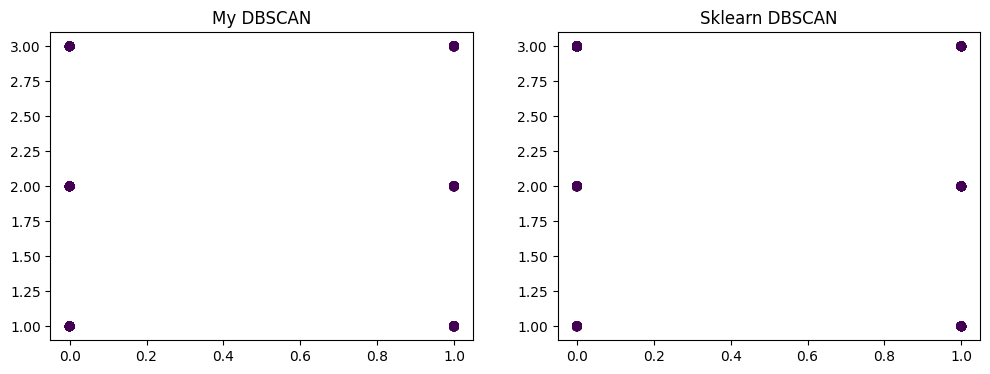

In [213]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("My DBSCAN")
plt.scatter(X[:, 0], X[:, 1], c=mydbscan.labels)
plt.subplot(122)
plt.title("Sklearn DBSCAN")
plt.scatter(X[:, 0], X[:, 1], c=sklearn_dbscan.labels_)
plt.show()

# Annulus

In [214]:
df_annulus = pd.read_csv('annulus.csv')

X_annulus = df_annulus.values

In [215]:
sklearn_dbscan.fit(X_annulus)

DBSCAN()

In [216]:
def plot_comparison(data,title_1,labels_1,title_2,labels_2):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.title(title_1)
    plt.scatter(data[:, 0], data[:, 1], c=labels_1)
    plt.subplot(122)
    plt.title(title_2)
    plt.scatter(data[:, 0], data[:, 1], c=labels_2)
    plt.show()

In [217]:
def load_data(filename):
    df = pd.read_csv(filename)
    return df.values


In [218]:
def fit_data(data,my_dbscan,sklearn_dbscan):
    my_dbscan.fit(data)
    sklearn_dbscan.fit(data)
    return my_dbscan.labels, sklearn_dbscan.labels_

# Annulus

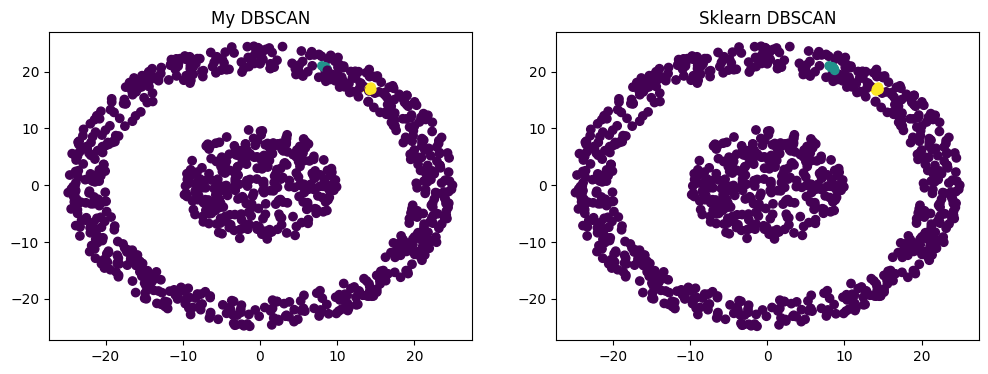

In [219]:
filename = 'annulus.csv'
data = load_data(filename)
my_dbscan_labels, sklearn_labels = fit_data(data,mydbscan,sklearn_dbscan)
plot_comparison(X_annulus,"My DBSCAN", my_dbscan_labels, "Sklearn DBSCAN", sklearn_labels)

# Boxes

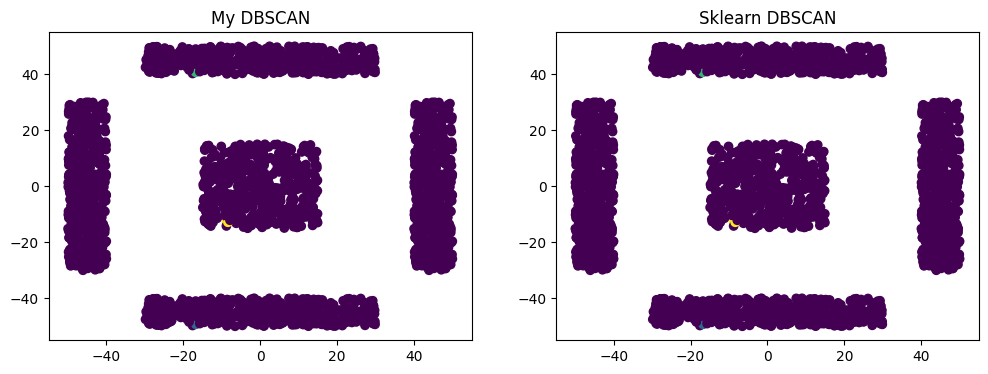

In [221]:
filename = 'boxes.csv'
data = load_data(filename)
my_dbscan_labels, sklearn_labels = fit_data(data,mydbscan,sklearn_dbscan)
plot_comparison(data,"My DBSCAN", my_dbscan_labels, "Sklearn DBSCAN", sklearn_labels)

# clusters3

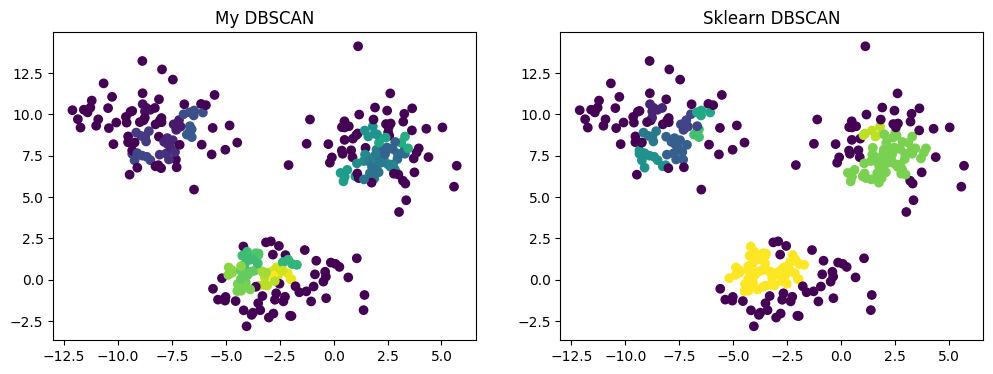

In [222]:
filename = 'clusters3.csv'
data = load_data(filename)
my_dbscan_labels, sklearn_labels = fit_data(data,mydbscan,sklearn_dbscan)
plot_comparison(data,"My DBSCAN", my_dbscan_labels, "Sklearn DBSCAN", sklearn_labels)

# clusters5

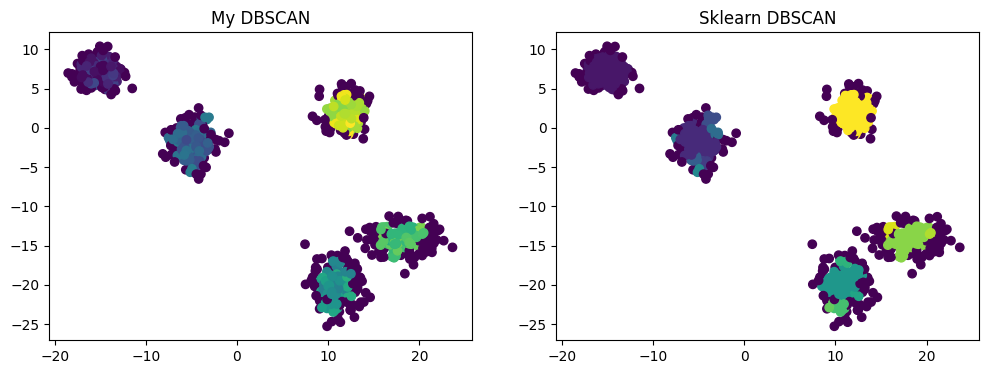

In [224]:
filename = 'clusters5.csv'
data = load_data(filename)
my_dbscan_labels, sklearn_labels = fit_data(data,mydbscan,sklearn_dbscan)
plot_comparison(data,"My DBSCAN", my_dbscan_labels, "Sklearn DBSCAN", sklearn_labels)

# clusters5n

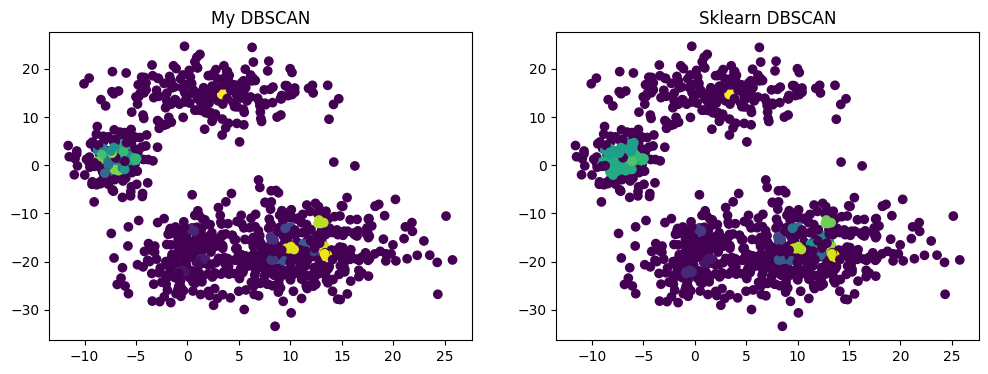

In [227]:
filename = 'clusters5n.csv'
data = load_data(filename)
my_dbscan_labels, sklearn_labels = fit_data(data,mydbscan,sklearn_dbscan)
plot_comparison(data,"My DBSCAN", my_dbscan_labels, "Sklearn DBSCAN", sklearn_labels)

# densegrid

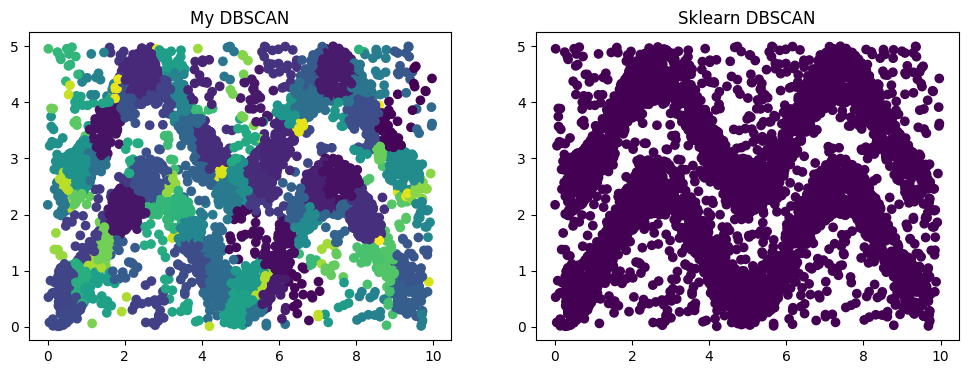

In [225]:
filename = 'densegrid.csv'
data = load_data(filename)
my_dbscan_labels, sklearn_labels = fit_data(data,mydbscan,sklearn_dbscan)
plot_comparison(data,"My DBSCAN", my_dbscan_labels, "Sklearn DBSCAN", sklearn_labels)